In [5]:
#https://github.com/ThilinaRajapakse/simpletransformers/blob/master/README.md#with-conda
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros

Using TensorFlow backend.


In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
from simpletransformers.classification import ClassificationModel
import pandas as pd

In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [91]:
df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])
y=df['category'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2) #train, test split
#validation split
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.1)

In [92]:
list_of_class={'not-malayalam':0,'Positive':1,'Negative':2,'unknown state':3,'Mixed feelings':4}
y_val=[list_of_class[i.strip()]for i in y_val]
y_train=[list_of_class[i.strip()]for i in y_train]
y_test=[list_of_class[i.strip()]for i in y_test]

In [93]:
class_weights

array([3.23783784, 1.797     , 0.48005343, 1.52503536, 0.71641196])

In [94]:
class_weights=[3.23783784, 1.797     , 0.48005343, 1.52503536, 0.71641196]
class_weights

[3.23783784, 1.797, 0.48005343, 1.52503536, 0.71641196]

In [95]:
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)

In [85]:
train_df

,0,1
0,Example sentence belonging to class 1,1
1,Example sentence belonging to class 0,0
2,Example eval senntence belonging to class 2,2


In [99]:
X_train

[' hoo mammokka police vesham aaha anthas',
 ' Oru rekshayum illa...kidilam kannu nananjupoyi',
 ' Ikka     waiting.........',
 ' Raju Ettante Oro Shorttum Ijathi ppwli',
 ' Ettan fansil netti poya aarenkilum undo?    #maduraraja#waiting #',
 ' Waiting to see mammukaas undaa 🤣',
 ' Last aa chadi adi.... Uff.        Frm an ettan fan',
 ' 1 day achu 5 million views kooda varla',
 ' heavy mass',
 ' I a m a katta mammookka fan',
 ' Pulimurgan 2 adyam oralde thallu. Pinne same kattil ottakkulla adi.',
 ' Nte ponno oru raksha Illa Ennaaa Trailer',
 ' Mammookka fans like adi. Love u ikka',
 ' Dislike adikan keri like adichath njaan mathramaano?',
 ' Enada Oru English comment kuda kanom',
 ' Oh mass o mass laletta katta waiting....Bgm',
 ' Ith powlichu vaariyitte pooku....',
 ' 7.3k dislike adichavanmaarod onne parayanollu......  OMKV',
 ' Malayali friends lalettan padam epdi irukku',
 ' June 16 Keralakara ilakki marikkum ikka',
 ' Ithu  Verum unda alla Machinegun  Nirachum undayulla machinegu

In [100]:
df_train=pd.DataFrame(X_train,y_train)

In [101]:
df_valid=pd.DataFrame(X_val,y_val)
df_test=pd.DataFrame(X_test,y_test)

In [71]:
df_train

,0
1,hoo mammokka police vesham aaha anthas
1,Oru rekshayum illa...kidilam kannu nananjupoyi
1,Ikka waiting.........
1,Raju Ettante Oro Shorttum Ijathi ppwli
1,Ettan fansil netti poya aarenkilum undo? #...
0,Waiting to see mammukaas undaa 🤣
1,Last aa chadi adi.... Uff. Frm an etta...
3,1 day achu 5 million views kooda varla
1,heavy mass
3,I a m a katta mammookka fan


In [54]:
df_train.to_csv('Malayalam_Code_Mix_train.csv',sep='\t',header=False)
df_valid.to_csv('Malayalam_Code_Mix_val.csv',sep='\t',header=False)
df_test.to_csv('Malayalam_Code_Mix_test.csv',sep='\t',header=False)

In [111]:
df_train=pd.read_csv('Malayalam_Code_Mix_train.csv',sep='\t',names=['category','text'])
df_test=pd.read_csv('Malayalam_Code_Mix_test.csv',sep='\t',names=['category','text'])
df_valid=pd.read_csv('Malayalam_Code_Mix_val.csv',sep='\t',names=['category','text'])

In [115]:
#df_valid=pd.read_csv('Malayalam_Code_Mix_val.csv',sep='\t',names=['f','m'])
df_valid=df_valid[['text','category']]
df_train=df_train[['text','category']]
df_test=df_test[['text','category']]
#df_valid

In [36]:
model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=5, args={'reprocess_input_data': True, 'overwrite_output_dir': True}) 
# You can set class weights by using the optional weight argument

I0130 16:23:35.464720 140673585157888 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /home/bharaj/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
I0130 16:23:35.466646 140673585157888 configuration_utils.py:199] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_

In [116]:
model.train_model(df_train)

Converting to features started. Cache is not used.


/home/bharaj/anaconda3/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:237: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


A Jupyter Widget


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


A Jupyter Widget

A Jupyter Widget

Running loss: 1.632540Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.626845Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 1.636695Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 1.408645Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 1.326772

I0130 16:55:05.194213 140673585157888 configuration_utils.py:87] Configuration saved in outputs/checkpoint-607-epoch-1/config.json


I0130 16:55:06.351758 140673585157888 modeling_utils.py:258] Model weights saved in outputs/checkpoint-607-epoch-1/pytorch_model.bin
I0130 16:55:07.035666 140673585157888 configuration_utils.py:87] Configuration saved in outputs/config.json


I0130 16:55:08.196585 140673585157888 modeling_utils.py:258] Model weights saved in outputs/pytorch_model.bin


Training of bert model complete. Saved to outputs/.


In [117]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid)

Converting to features started. Cache is not used.


/home/bharaj/anaconda3/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:568: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


A Jupyter Widget

A Jupyter Widget


{'mcc': 0.4532191514531107, 'eval_loss': 1.0301488725578083}


In [118]:
predictions, raw_outputs = model.predict(df_test['text'])

Converting to features started. Cache is not used.


A Jupyter Widget

A Jupyter Widget

In [121]:
predictions


array([3, 3, 1, ..., 1, 3, 1])

In [123]:
list_of_class_v={0:'not-malayalam',1:'Positive',2:'Negative',3:'unknown state',4:'Mixed feelings'}

In [125]:
print(classification_report([list_of_class_v[i] for i in y_test], 
                            [list_of_class_v[i] for i in predictions]))

                precision    recall  f1-score   support

Mixed feelings       0.00      0.00      0.00        70
      Negative       0.61      0.27      0.37       138
      Positive       0.59      0.79      0.67       565
 not-malayalam       0.73      0.82      0.78       177
 unknown state       0.63      0.53      0.57       398

     micro avg       0.62      0.62      0.62      1348
     macro avg       0.51      0.48      0.48      1348
  weighted avg       0.59      0.62      0.59      1348



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


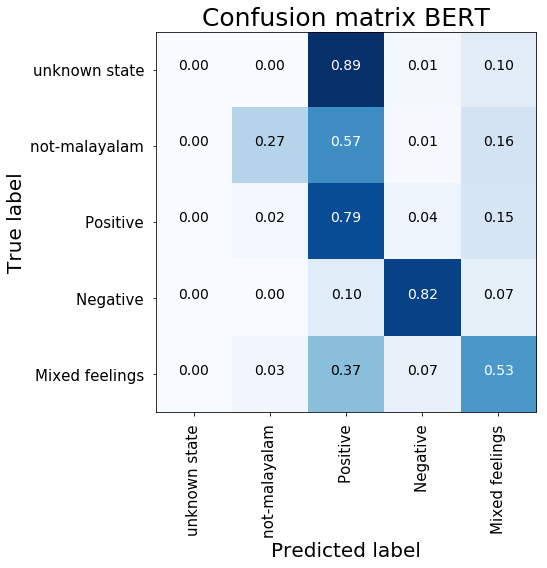

In [127]:
cnf_matrix = confusion_matrix([list_of_class_v[i] for i in y_test], 
                              [list_of_class_v[i] for i in predictions])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix BERT")
plt.show()